In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolor
import scipy.stats as stats
from scipy.interpolate import make_interp_spline

In [3]:
robosense_pkl_path = '/home/cws-ml-lab/mmdetection3d_for_rail/data/robosense_m1_plus_sequences/kitti_infos_trainval.pkl'

In [4]:
robosense_dataset = pickle.load(open(robosense_pkl_path, 'rb'))

data_list = robosense_dataset['data_list']

In [5]:
robosense_dataset

{'metainfo': {'categories': {'Pedestrian': 0, 'Cyclist': 1, 'Car': 2},
  'dataset': 'kitti',
  'info_version': '1.1'},
 'data_list': [{'sample_idx': '00451.bin',
   'lidar_points': {'num_pts_feats': 4,
    'lidar_path': 'Alte_Winterthurerstrasse_1_00451.bin'},
   'instances': [{'bbox': [0.0, 0.0, 0.0, 0.0],
     'bbox_label': 1,
     'bbox_3d': [22.092123,
      19.175591,
      -0.5520780000000001,
      1.947541,
      1.150121,
      1.966136,
      -2.014579],
     'bbox_label_3d': 1,
     'difficulty': -1,
     'truncated': 0.0,
     'occluded': 0,
     'alpha': 0.0,
     'score': 0.0,
     'index': 0,
     'group_id': 0},
    {'bbox': [0.0, 0.0, 0.0, 0.0],
     'bbox_label': 2,
     'bbox_3d': [25.576168,
      29.320494,
      -0.8925259999999999,
      3.75251,
      2.352051,
      1.7085,
      -1.947508],
     'bbox_label_3d': 2,
     'difficulty': -1,
     'truncated': 0.0,
     'occluded': 0,
     'alpha': 0.0,
     'score': 0.0,
     'index': 1,
     'group_id': 1},
    {

In [6]:
bbox_3d_list = []
label_list = []
for data in data_list:
    for instances in data['instances']:
        bbox_3d_list.append(instances['bbox_3d'])
        label_list.append(instances['bbox_label_3d'])
        
bbox_3d_list = np.array(bbox_3d_list)
label_list = np.array(label_list)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


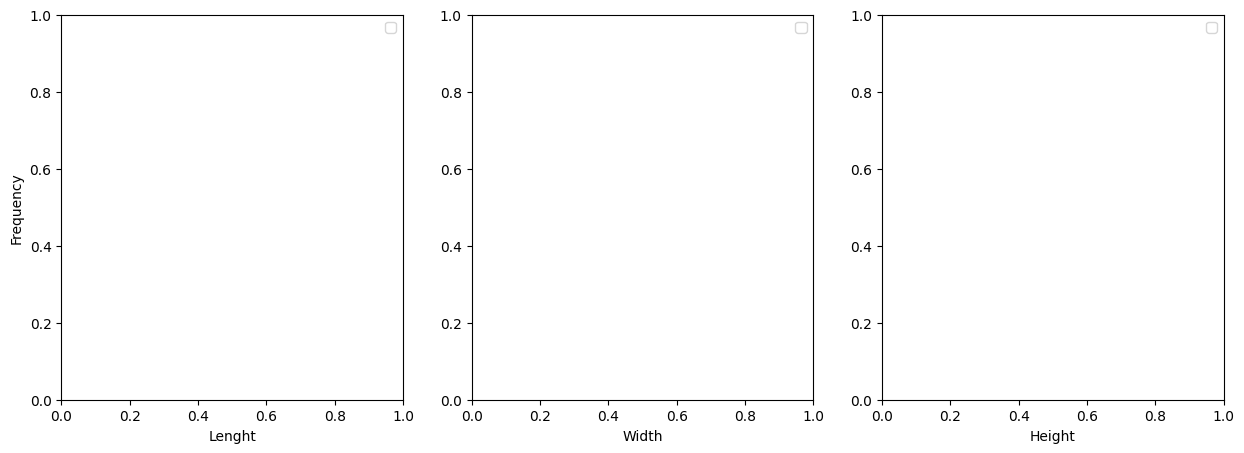

In [7]:
# For each unique label, create a histogram of the h, w, l values of the bounding boxes

unique_labels = np.unique(label_list)

# remove -1 from unique labels
unique_labels = unique_labels[unique_labels != -1]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, label in enumerate(unique_labels):
    indices = np.where(label_list == label)[0]
    
    mean_h = np.mean(bbox_3d_list[indices, 3])
    mean_w = np.mean(bbox_3d_list[indices, 4])
    mean_l = np.mean(bbox_3d_list[indices, 5])
    
    _label_h = f'{label} (mean: {mean_h:.2f})'
    _label_w = f'{label} (mean: {mean_w:.2f})'
    _label_l = f'{label} (mean: {mean_l:.2f})'

ax[0].set_xlabel('Lenght')
ax[1].set_xlabel('Width')
ax[2].set_xlabel('Height')

ax[0].set_ylabel('Frequency')

ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.show()

# Groundtruth database analysis

In [8]:
kitti_dataset_info_path = '/home/cws-ml-lab/mmdetection3d_for_rail/data/kitti/kitti_dbinfos_train.pkl'
osdar_dataset_info_path = '/home/cws-ml-lab/mmdetection3d_for_rail/data/osdar23_3class/kitti_dbinfos_train.pkl'
robosense_dataset_info_path = '/home/cws-ml-lab/mmdetection3d_for_rail/data/robosense_m1_plus_sequences/kitti_dbinfos_train.pkl'

# Load the dataset infos
kitti_dataset_info = pickle.load(open(kitti_dataset_info_path, 'rb'))
osdar_dataset_info = pickle.load(open(osdar_dataset_info_path, 'rb'))
robosense_dataset_info = pickle.load(open(robosense_dataset_info_path, 'rb'))

In [9]:
# top level keys from osdar dataset info
osdar_dataset_info.keys()

dict_keys(['Pedestrian', 'Car', 'Cyclist'])

In [38]:
# density = stats.gaussian_kde(distance_list)

# bins = np.linspace(0, 80, 81)

# n, x, _ = plt.hist(distance_list, bins=bins, alpha=0.5, label='Histogram of Number of Points in Bounding Box', density=True)

# plt.plot(x, density(x), label='Gaussian KDE')

# plt.title('Histogram and Gaussian KDE of Distance to Sensor')

plt.show()

In [10]:
def average_num_pts_points_binning(num_points_list, distance_list, binning_distance = 1, max_distance = None):
    
    # make sure that num_points_list and distance_list have the same length
    assert len(num_points_list) == len(distance_list)
    
    # and that they are numpy arrays
    num_points_list = np.array(num_points_list)
    distance_list = np.array(distance_list)
    
    # sort according to distance
    sorted_indices = np.argsort(distance_list)
    distance_list = distance_list[sorted_indices]
    num_points_list = num_points_list[sorted_indices]
    
    if max_distance is None:
        max_distance = int(np.max(distance_list))
    
    # discard points that are further than max_distance
    new_distance_list = distance_list[distance_list < max_distance]
    num_points_list = num_points_list[distance_list < max_distance]
    
    # create bins
    bins = np.linspace(0, max_distance, max_distance // binning_distance + 1)
    
    # create a list to store the average number of points in each bin
    average_num_points = []
    
    # create a list to store the number of points in each bin
    num_objects = []
    
    
    for i in range(len(bins) - 1):
        indices = np.where((new_distance_list >= bins[i]) & (new_distance_list < bins[i + 1]))[0]
        
        if len(indices) == 0:
            average_num_points.append(0)
            num_objects.append(0)
        else:
            average_num_points.append(np.median(num_points_list[indices]))
            num_objects.append(len(indices))
            
    return average_num_points, num_objects, bins

In [11]:
from scipy.interpolate import make_interp_spline

### Num points per class plot

In [12]:
stadler_blue = (30, 90, 154)
stadler_yellow = (255, 189, 0)
stadler_grey = (192,192,192)

# devide by 255
stadler_blue = (30/255, 90/255, 154/255)
stadler_yellow = (255/255, 189/255, 0/255)
stadler_grey = (192/255, 192/255, 192/255)

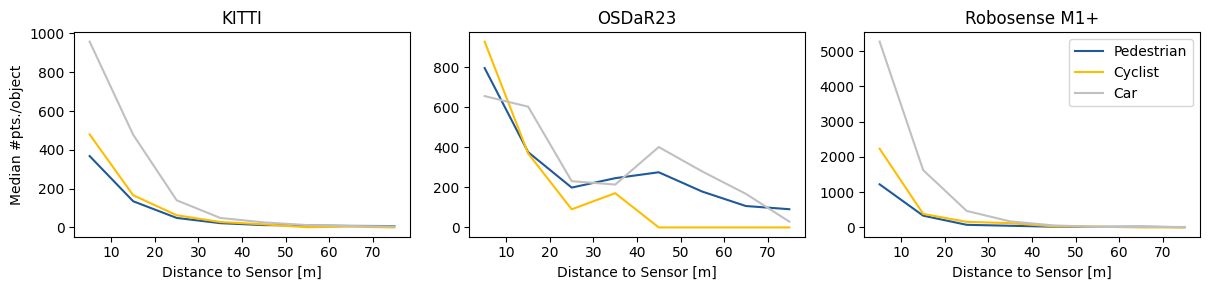

In [17]:
# Create a plot with three horizontal subplots
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
ax1, ax2, ax3 = ax

# Kitti Dataset

for i, _class in enumerate(['Pedestrian', 'Cyclist', 'Car']):
    
    class_info = kitti_dataset_info[_class]
    
    bbox_3d_list = []
    num_points_list = []

    for value in class_info:
        bbox_3d_list.append(value['box3d_lidar'])
        num_points_list.append(value['num_points_in_gt'])

    bbox_3d_list = np.array(bbox_3d_list)
    distance_list = np.sqrt(np.sum(bbox_3d_list[:, :3] ** 2, axis=1))
    
    median_num_lidar_points, num_objects, bins = average_num_pts_points_binning(num_points_list, distance_list, binning_distance=10, max_distance=80)
    
    mid_points = (bins[:-1] + bins[1:]) / 2

    ax1.plot(mid_points, median_num_lidar_points, label=_class, color=[stadler_blue, stadler_yellow, stadler_grey][i])

ax1.set_title('KITTI')
ax1.set_xlabel('Distance to Sensor [m]')

# OSDAR Dataset

for i, _class in enumerate(['Pedestrian', 'Cyclist', 'Car']):
        
    class_info = osdar_dataset_info[_class]
    
    bbox_3d_list = []
    num_points_list = []

    for value in class_info:
        bbox_3d_list.append(value['box3d_lidar'])
        num_points_list.append(value['num_points_in_gt'])

    bbox_3d_list = np.array(bbox_3d_list)
    distance_list = np.sqrt(np.sum(bbox_3d_list[:, :3] ** 2, axis=1))
    
    median_num_lidar_points, num_objects, bins = average_num_pts_points_binning(num_points_list, distance_list, binning_distance=10, max_distance=80)
    
    # ax2.plot(bins[:-1], median_num_lidar_points, label=_class)

    mid_points = (bins[:-1] + bins[1:]) / 2
    

    ax2.plot(mid_points, median_num_lidar_points, label=_class, color=[stadler_blue, stadler_yellow, stadler_grey][i])
        
ax2.set_title('OSDaR23')
ax2.set_xlabel('Distance to Sensor [m]')

# Robosense Dataset

for i, _class in enumerate(['Pedestrian', 'Cyclist', 'Car']):
            
        class_info = robosense_dataset_info[_class]
        
        bbox_3d_list = []
        num_points_list = []
    
        for value in class_info:
            bbox_3d_list.append(value['box3d_lidar'])
            num_points_list.append(value['num_points_in_gt'])
    
        bbox_3d_list = np.array(bbox_3d_list)
        distance_list = np.sqrt(np.sum(bbox_3d_list[:, :3] ** 2, axis=1))
        
        median_num_lidar_points, num_objects, bins = average_num_pts_points_binning(num_points_list, distance_list, binning_distance=10, max_distance=80)

        mid_points = (bins[:-1] + bins[1:]) / 2

        ax3.plot(mid_points, median_num_lidar_points, label=_class, color=[stadler_blue, stadler_yellow, stadler_grey][i])
 
ax3.set_title('Robosense M1+')
ax3.set_xlabel('Distance to Sensor [m]')
ax3.legend()


x_min = min(_ax.get_xlim()[0] for _ax in ax)
x_max = max(_ax.get_xlim()[1] for _ax in ax)

# y_max = 15000

# for _ax in ax:
#     _ax.set_xlim(x_min, x_max)
#     _ax.set_ylim(0, y_max)

plt.tight_layout()

ax1.set_ylabel('Median #pts./object')

plt.savefig('240913_num_pts_per_object.png', dpi=600, bbox_inches='tight', pad_inches=0)
    


### Densitiy distribution plot

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


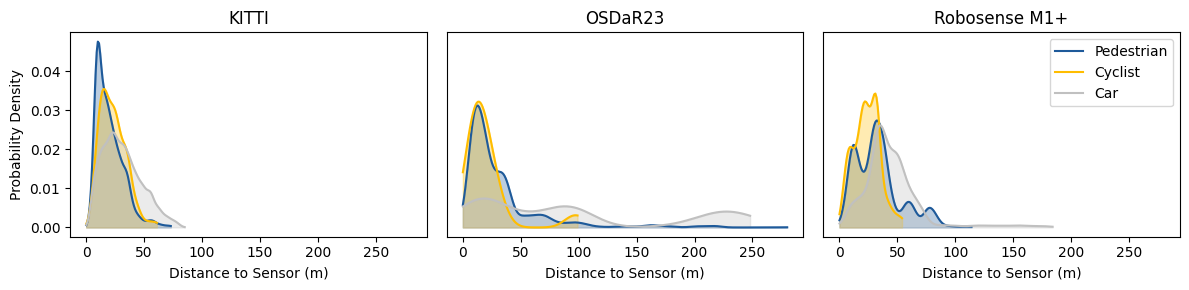

In [18]:
# Create a plot with three horizontal subplots
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
ax1, ax2, ax3 = ax
plt.rc('font', family='Times New Roman')
# Set figure title
# fig.suptitle('Estim. Gaussian PDF of Object Distance to Sensor')

# Kitti Dataset

for i, _class in enumerate(['Pedestrian', 'Cyclist', 'Car']):
    
    class_info = kitti_dataset_info[_class]
    
    bbox_3d_list = []
    num_points_list = []

    for value in class_info:
        bbox_3d_list.append(value['box3d_lidar'])
        num_points_list.append(value['num_points_in_gt'])

    bbox_3d_list = np.array(bbox_3d_list)
    distance_list = np.sqrt(np.sum(bbox_3d_list[:, :3] ** 2, axis=1))
    
    median_num_lidar_points, num_objects, bins = average_num_pts_points_binning(num_points_list, distance_list, binning_distance=1)
    density = stats.gaussian_kde(distance_list)
    
    ax1.plot(bins[:-1], density(bins[:-1]), label=_class, color=[stadler_blue, stadler_yellow, stadler_grey][i])
    ax1.fill_between(bins[:-1], density(bins[:-1]), alpha=0.3, color=[stadler_blue, stadler_yellow, stadler_grey][i])
    
ax1.set_title('KITTI')
ax1.set_xlabel('Distance to Sensor (m)')
ax1.set_ylabel('Probability Density')

# OSDAR Dataset

for i, _class in enumerate(['Pedestrian', 'Cyclist', 'Car']):
            
        class_info = osdar_dataset_info[_class]
        
        bbox_3d_list = []
        num_points_list = []
    
        for value in class_info:
            bbox_3d_list.append(value['box3d_lidar'])
            num_points_list.append(value['num_points_in_gt'])
    
        bbox_3d_list = np.array(bbox_3d_list)
        distance_list = np.sqrt(np.sum(bbox_3d_list[:, :3] ** 2, axis=1))
        
        median_num_lidar_points, num_objects, bins = average_num_pts_points_binning(num_points_list, distance_list, binning_distance=1)
        
        density = stats.gaussian_kde(distance_list)
        
        ax2.plot(bins[:-1], density(bins[:-1]), label=_class, color=[stadler_blue, stadler_yellow, stadler_grey][i])
        ax2.fill_between(bins[:-1], density(bins[:-1]), alpha=0.3, color=[stadler_blue, stadler_yellow, stadler_grey][i])

        # ax2.plot(bins[:-1], median_num_lidar_points, label=_class)
        
ax2.set_title('OSDaR23')
ax2.set_xlabel('Distance to Sensor (m)')
ax2.yaxis.set_visible(False)

# Robosense Dataset

for i, _class in enumerate(['Pedestrian', 'Cyclist', 'Car']):
    
    class_info = robosense_dataset_info[_class]
    
    bbox_3d_list = []
    num_points_list = []

    for value in class_info:
        bbox_3d_list.append(value['box3d_lidar'])
        num_points_list.append(value['num_points_in_gt'])

    bbox_3d_list = np.array(bbox_3d_list)
    distance_list = np.sqrt(np.sum(bbox_3d_list[:, :3] ** 2, axis=1))
    
    median_num_lidar_points, num_objects, bins = average_num_pts_points_binning(num_points_list, distance_list, binning_distance=1)
    
    density = stats.gaussian_kde(distance_list)
    
    ax3.plot(bins[:-1], density(bins[:-1]), label=_class, color=[stadler_blue, stadler_yellow, stadler_grey][i])
    ax3.fill_between(bins[:-1], density(bins[:-1]), alpha=0.3, color=[stadler_blue, stadler_yellow, stadler_grey][i])
    
ax3.set_title('Robosense M1+')
ax3.set_xlabel('Distance to Sensor (m)')
ax3.yaxis.set_visible(False)
ax3.legend()

y_min = min(_ax.get_ylim()[0] for _ax in ax)
y_max = max(_ax.get_ylim()[1] for _ax in ax)
x_min = min(_ax.get_xlim()[0] for _ax in ax)
x_max = max(_ax.get_xlim()[1] for _ax in ax)

for _ax in ax:
    _ax.set_ylim(y_min, y_max)
    _ax.set_xlim(x_min, x_max)


plt.tight_layout()

plt.savefig('240913_object_density.png', dpi=600, bbox_inches='tight', pad_inches=0)